<h1>Quick tour</h1>
______________________________

## Introduction
______________________________

**BlindBox** protects SaaS users' data. It wraps applications in a **sandbox with customizable access** possibilities and **deploys** them on **Confidential VMs**, which provide **robust hardware based isolation and protection**. When clients connect to a BlindBox and query the application with their data, the service provider has no way of accessing or seeing this data - hence our name BlindBox! 

Using BlindBox happens in 4 steps:

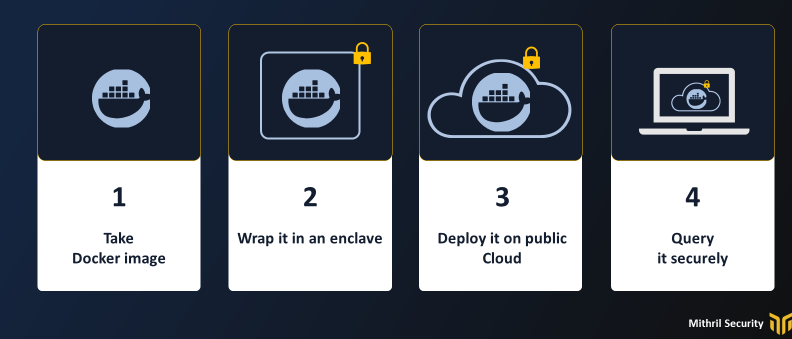

## Quick start guide
______________________

We'll use an image containing [OpenAI's Whisper model](https://huggingface.co/spaces/openai/whisper) as the example software to walk you through how you can use BlindBox.

### Pre-requisites

To follow along with this guide and deploy your own BlindBox, you will need:

+ An **Azure account** and **credits**. 

	> **Important**: Our quick tour deploys a Whisper app on a DCasv5/ECasv5 series confidential VM with Azure. If you follow along with the Quick Tour, you will be charged according to your usage as detailed by Azure. You can get a detailed pricing quote [here](https://learn.microsoft.com/en-us/azure/confidential-computing/confidential-vm-overview).

+ Have Docker installed in your environment. Here's the [Docker installation guide](https://docs.docker.com/desktop/install/linux-install/).

#### Installing BlindBox and Terraform

Let's dive in! We'll first need to install the **[blindbox](https://pypi.org/project/blindbox/) PyPi package** and **`terraform`**. **Terraform** is a dependency which facilitates the deployment of our BlindBox.

In [ ]:
# install blindbox
!pip install blindbox

# Download terraform
!wget -O- https://apt.releases.hashicorp.com/gpg | sudo gpg --dearmor -o /usr/share/keyrings/hashicorp-archive-keyring.gpg

# Add terraform to trusted apt packages
!echo "deb [signed-by=/usr/share/keyrings/hashicorp-archive-keyring.gpg] https://apt.releases.hashicorp.com $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/hashicorp.list

# Install terraform
!sudo apt update && sudo apt install terraform

#### Azure CLI and login

We will also need to download the **Azure CLI tool** and **log in** to our Azure account.

In [ ]:
# Install azure-cli
!curl -sL https://aka.ms/InstallAzureCLIDeb | sudo bash

# Install confcom extension for azure-cli
!az extension add -n confcom

# Log in using azure-cli
!az login

# Set the subscription azure-cli will use by default.
!az account set --subscription "Microsoft Azure Sponsorship"

When running the `az login` command, you will be provided with a link that you will need to open in your browser to successfully login to your Azure account.

#### Download the audio file

The final requirement is to download our [test audio file](https://www2.cs.uic.edu/~i101/SoundFiles/taunt.wav) which we will use to query our Whisper model. This one was provided by University of Illinois at Chicago  as part of their Computer Science 101 course.

In [ ]:
# Download our example audio file and save it as `test.wav` in a `.tmp` folder

!mkdir -p .tmp
!wget https://www2.cs.uic.edu/~i101/SoundFiles/taunt.wav -O .tmp/test.wav

#### Preparing the BlindBox

A final preliminary step is to initialize our BlindBox with the `blindbox init` command. This step will automatically create two template configuration files needed for our BlindBox which users can modify to apply custom settings and policies to their blindbox: 

+ A `blindbox.yml` file which currently supports the following modifiable options:
	+ `platform` to specify the TEE type you want to use (we currently only support `amd-sev`)
	+ **coming soon**: `ip-rules` to whitelist the `ip addresses` of the users allowed to query the BlindBox application. 

	> The `blindbox.yml` config file should be modified **before building** your BlindBox for any changes to take effect. 

+ A `blindbox.tf` file. It contains all the configuration options for the Confidential VM which your BlindBox image will be deployed on. 

	> The `blindbox.tf` config file should be modified **before deploying **your BlindBox for any changes to take effect.

In [ ]:
# initialize the blindbox
!blindbox --platform azure-sev init 

We specify that we want to use the AMD SEV TEE platform with Azure using the `platform` option with `azure-sev` as our argument.

> This is the only platform currently supported. `aws-nitro` is **coming soon**.

### **#1**. Preparing the application image

In BlindBox architecture, the "inner" application image will be wrapped within an "outer" BlindBox image. The outer image is responsible for implementing customizable security policy and **communicates** with the inner image **using port 80**.

This is why, to be compatible with BlindBox, applications images only need to fill one requirement: they must expose `port 80`. 

You can download the Docker image we prepared for this tutorial in the `ai_server_example` folder of the `BlindBox repository`:

In [ ]:
!git clone https://github.com/mithril-security/blindbox
!cd ai_server_example

We can now build our Whisper application image so it is ready to be deployed with BlindBox.

In [ ]:
# build Whisper application assigning it the tag "myimage"
!docker build -t myimage .

### **#2**. Wrapping the app in our custom security layer

This is where things start to get interesting! We are now going to wrap our application image in a BlindBox security image, which will act as a customizable sandbox, offering protections for both users' data and the IP of the application. The security policies implemented are specified in the `blindbox.yml` file. Note, that the full range of security features which can be implemented at this stage are still **under development**!

#### Building the BlindBox image

To do this, we use `blindbox build` and specifying the application image using the `--source-image` option.

In [ ]:
# build the application image with the tag "myimage-blindbox:v1"
!blindbox build -t myimage-blindbox:v1 --source-image myimage

>We recommend closing any applications running on your machine before calling `blindbox build`. This is because the process is memory intensive and can silently fail at this stage if there are too many applications running on the machine in question. This would lead to a `DeploymentFailed` error when deploying your blindbox.

### **#3**. Deploy the BlindBox image

We next use the `deploy` command to deploy our `blindbox image` (which contains the inner `application image`) on an `Azure confidential VM`. 

In [ ]:
# deploy our image inside Confidential VM using BlindBox
!blindbox deploy myimage-blindbox:v1

### **#4**. Querying the Confidential VM

Now that the deployment is done, authorised users can query the model within the Confidential VM using the `requests` module within the `blindbox` library we installed earlier on.

In [ ]:
# import requests module
from blindbox  import requests

CONFIDENTIAL_VM_IP_ADDRESS = "127.0.0.1" # replace with your VM IP address

# we query our application, sending it our audio file
res = requests.post(url= CONFIDENTIAL_VM_IP_ADDRESS + ":8080/enclave/predict", files={"audio": open(".tmp/test.wav", "rb")})

# display result
print(res)

## Conclusion
_______________________
 
Now that we've seen how we can deploy and query an application with BlindBox, let's find out more about how BlindBox protects end users' data in the following [section](./confidential_computing.md).